In [1]:
import re
import operator
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
from pyspark.ml.feature import Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark.sql.functions import udf, concat_ws, lit, col, explode
from pyspark.sql.types import StringType,FloatType

spark = SparkSession.builder.appName('er').getOrCreate()
spark.sparkContext.setLogLevel('WARN')

In [2]:
job_details=spark.read.option('compression', 'gzip').json('er_resume_preprocessed')
job_details.registerTempTable("job_details")
job_details.show()

+-----------+--------------------+--------------------+----------------+
|         id|         job_details|           job_title|       resume_id|
+-----------+--------------------+--------------------+----------------+
|25769803776|[accepting, calls...|     [office, clerk]|7b9c4b06a9e8eff1|
|25769803777|[print, scan, shr...|     [office, clerk]|75fd84276b7f61ce|
|25769803778|[enter, mails, fi...|     [office, clerk]|af70af4861df88f0|
|25769803779|[office, loading,...|     [office, clerk]|7f2b13910db89d24|
|25769803780|[328, north, rive...|     [office, clerk]|c7e51c2ae59abc4b|
|25769803781|[responsibilities...|     [office, clerk]|90213a5d4c0ea6be|
|25769803782|[lower, sackville...|     [office, clerk]|67761a732de12577|
|25769803783|[performed, routi...|     [office, clerk]|69c935a303746b81|
|25769803784|[cameroon, answer...|     [office, clerk]|2efbb1e161bee89d|
|25769803785|[input, data, com...|     [office, clerk]|b1340a1ce0961fa6|
|25769803786|[handled, filing,...|       [file, cle

In [3]:
job_titles=spark.read.option('compression', 'gzip').json('er_titles_preprocessed')
job_titles.registerTempTable("job_titles")
job_titles.show()

+--------------------+--------------+----------------+---+
|     Alternate Title|O*NET-SOC Code|           Title| id|
+--------------------+--------------+----------------+---+
|[aeronautics, com...|    11-1011.00|Chief Executives|  0|
|[agricultural, se...|    11-1011.00|Chief Executives|  1|
|[alcohol, drug, a...|    11-1011.00|Chief Executives|  2|
|[arts, humanities...|    11-1011.00|Chief Executives|  3|
|   [bakery, manager]|    11-1011.00|Chief Executives|  4|
|   [bank, president]|    11-1011.00|Chief Executives|  5|
|   [book, publisher]|    11-1011.00|Chief Executives|  6|
|[brokerage, offic...|    11-1011.00|Chief Executives|  7|
|     [bureau, chief]|    11-1011.00|Chief Executives|  8|
|[business, develo...|    11-1011.00|Chief Executives|  9|
|[business, develo...|    11-1011.00|Chief Executives| 10|
|[business, enterp...|    11-1011.00|Chief Executives| 11|
|[business, execut...|    11-1011.00|Chief Executives| 12|
| [cemetery, manager]|    11-1011.00|Chief Executives| 1

In [4]:
resume_ids = spark.read.option('compression', 'gzip').json('er_result')
resume_ids.registerTempTable("resume_ids")
resume_ids.show()

+--------------+-----+---+------------------+----------------+
|O*NET-SOC Code|  id1|id2|           jaccard|       resume_id|
+--------------+-----+---+------------------+----------------+
|    15-1133.00| 4885| 65|0.6666666666666666|93de10bb2dd5b81f|
|    41-9031.00|24724| 65|               0.5|93de10bb2dd5b81f|
|    15-1132.00| 4833| 65|               0.5|93de10bb2dd5b81f|
|    15-1199.01| 5285| 65|               0.5|93de10bb2dd5b81f|
|    17-2141.01| 6725| 65|               0.5|93de10bb2dd5b81f|
|    17-2141.02| 6747| 65|               0.5|93de10bb2dd5b81f|
|    15-1133.00| 4882| 65|               0.5|93de10bb2dd5b81f|
|    15-1132.00| 4845| 65|               0.5|93de10bb2dd5b81f|
|    15-1199.02| 5309| 65|               0.5|93de10bb2dd5b81f|
|    17-2199.05| 7020| 65|               0.5|93de10bb2dd5b81f|
|    15-1199.01| 5282| 65|               0.5|93de10bb2dd5b81f|
|    15-1134.00| 4942| 65|               0.5|93de10bb2dd5b81f|
|    17-2199.05| 7021| 65|               0.5|93de10bb2d

In [5]:
joined_data=spark.sql("SELECT a.`Alternate Title`as alternate_title,a.`O*NET-SOC Code` as onet_code, a.Title, b.id1, b.id2, b.jaccard, b.resume_id, c.job_details, c.job_title FROM job_titles a JOIN resume_ids b ON a.id = b.id1 JOIN job_details c ON b.id2 = c.id")
joined_data.registerTempTable("data")

In [6]:
joined_data.show()

+--------------------+----------+--------------------+-----+---+------------------+----------------+--------------------+--------------------+
|     alternate_title| onet_code|               Title|  id1|id2|           jaccard|       resume_id|         job_details|           job_title|
+--------------------+----------+--------------------+-----+---+------------------+----------------+--------------------+--------------------+
|[software, system...|15-1199.02|Computer Systems ...| 5310| 26|0.6666666666666666|388daff777202464|[cairo, egypt, se...|[software, engineer]|
|[software, system...|15-1133.00|Software Develope...| 4887| 26|0.6666666666666666|388daff777202464|[cairo, egypt, se...|[software, engineer]|
|          [engineer]|17-3023.03|Electrical Engine...| 7466| 26|               0.5|388daff777202464|[cairo, egypt, se...|[software, engineer]|
|          [engineer]|17-2161.00|   Nuclear Engineers| 6787| 26|               0.5|388daff777202464|[cairo, egypt, se...|[software, engineer]|

In [6]:
pie_df = spark.sql("SELECT jaccard, count(jaccard) as count, count(jaccard)*100.0/(select count(id1) from data) as percentage from data group by jaccard")
pie_df.show()

+------------------+--------+-----------------+
|           jaccard|   count|       percentage|
+------------------+--------+-----------------+
|               1.0| 1066036| 6.23158463787386|
|0.7142857142857143|       4| 0.00002338226716|
|               0.6|   39799| 0.23264771265017|
|               0.8|     213| 0.00124510572614|
|0.6666666666666666| 2428857|14.19804581533118|
|               0.5|13474334|78.76511933929195|
|              0.75|   97607| 0.57056823761013|
|0.8333333333333334|       8| 0.00004676453431|
|0.5714285714285714|     123| 0.00071900471509|
+------------------+--------+-----------------+



In [9]:
pie_df = pie_df.toPandas()

In [10]:
pie_df

,jaccard,count,percentage
0,1.000000,1066036,6.23158463787386
1,0.714286,4,0.00002338226716
2,0.600000,39799,0.23264771265017
3,0.800000,213,0.00124510572614
4,0.666667,2428857,14.19804581533118
5,0.500000,13474334,78.76511933929195
6,0.750000,97607,0.57056823761013
7,0.833333,8,0.00004676453431
8,0.571429,123,0.00071900471509


In [33]:
pie_df = pie_df[pie_df['percentage']>0.2]
pie_df

,jaccard,count,percentage
0,1.00,1066036,1
2,0.60,39799,0.6
4,0.67,2428857,0.67
5,0.50,13474334,0.5
6,0.75,97607,0.75


In [39]:
pie_df = pie_df.reset_index()

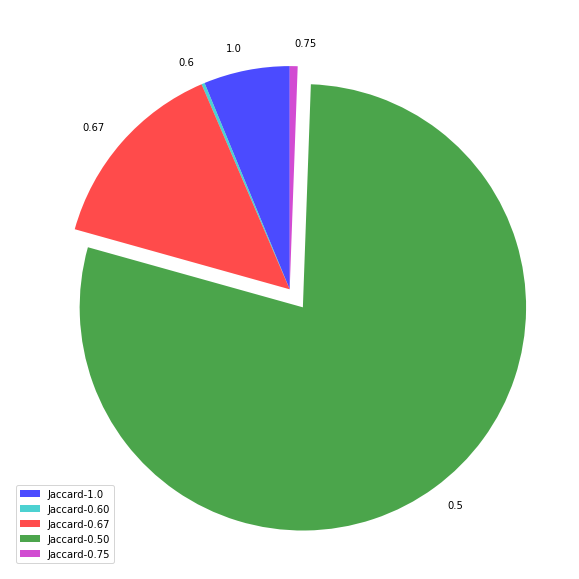

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mp
import numpy as np
from matplotlib import cm

pie_df['jaccard'] = pie_df['jaccard'].round(2)
colors = ['b', 'c', 'r', 'g', 'm']
labels = ['Jaccard-1.0','Jaccard-0.60','Jaccard-0.67','Jaccard-0.50','Jaccard-0.75']
explode = (0, 0, 0, 0.1, 0)
cs=cm.Set1(np.arange(12)/12.)


plt.figure(figsize=(10,15))

plt.pie(pie_df["count"],explode=explode, colors=colors, labels=pie_df["jaccard"],startangle=90,wedgeprops={'alpha':0.7})
plt.legend(labels,loc=3)
plt.show()

In [60]:
jaccard_data_1 = spark.sql("SELECT count(alternate_title) as count FROM data where jaccard <= 0.6 and jaccard = 0.5 ")
jaccard_data_1.show()

+--------+
|   count|
+--------+
|13474334|
+--------+



In [61]:
jaccard_data_1.toPandas().reset_index().rename({'index':'id'},axis=1)

,id,count
0,0,13474334


In [59]:
jaccard_data_1

DataFrame[count: bigint]

In [44]:
jaccard_data_1['count'].values[0]

Column<b'count[values][0]'>

In [17]:
total_count = spark.sql("SELECT count(alternate_title) as count FROM data")
total_count.show()

+--------+
|   count|
+--------+
|17106981|
+--------+



In [13]:
jaccard_data_2 = spark.sql("SELECT count(alternate_title) as count FROM data where jaccard <= 0.7 and jaccard > 0.6 ")
jaccard_data_2.show()

+-------+
|  count|
+-------+
|2428857|
+-------+



In [14]:
jaccard_data_3 = spark.sql("SELECT count(alternate_title) as count FROM data where jaccard <= 0.8 and jaccard > 0.7 ")
jaccard_data_3.show()

+-----+
|count|
+-----+
|97824|
+-----+



In [15]:
jaccard_data_4 = spark.sql("SELECT count(alternate_title) as count FROM data where jaccard <= 0.9 and jaccard > 0.8 ")
jaccard_data_4.show()

+-----+
|count|
+-----+
|    8|
+-----+



In [16]:
jaccard_data_5 = spark.sql("SELECT count(alternate_title) as count FROM data where jaccard <= 1.0 and jaccard > 0.9 ")
jaccard_data_5.show()

+-------+
|  count|
+-------+
|1066036|
+-------+



In [6]:
grouped_data = spark.sql("SELECT alternate_title,id1 FROM data group by alternate_title, id1")
grouped_data.show()
joined_data.registerTempTable("grouped_data")

+--------------------+-----+
|     alternate_title|  id1|
+--------------------+-----+
|[web, software, e...| 4942|
|         [professor]|13551|
|[assistant, profe...|12793|
|[system, developm...| 7022|
|  [road, consultant]|26488|
|[engineering, con...| 6878|
|[security, consul...|20580|
|[supplier, qualit...| 4838|
|[supplier, qualit...| 6580|
|[operations, anal...| 3413|
|[compliance, anal...| 3092|
|[continuous, impr...| 3344|
|[quality, special...|10190|
|[graphics, specia...|15226|
|[sales, support, ...|23862|
| [wildlife, manager]| 8280|
|[substation, mana...| 1032|
| [resident, manager]| 1802|
| [planning, manager]| 8872|
|     [band, manager]| 2580|
+--------------------+-----+
only showing top 20 rows



In [6]:
job_titles_d = spark.sql("SELECT job_title FROM data group by job_title")

In [7]:
job_titles_df = job_titles_d.toPandas()
job_titles_df.head()

,job_title
0,"[front, desk, supervisor]"
1,"[janitor, lead, hand]"
2,"[investment, operations, representative]"
3,"[mobile, operator]"
4,"[program, host]"


In [8]:
titles_list = []
for j in job_titles_df['job_title']:
    for i in j:
        titles_list.append(i)
titles_list

['front',
 'desk',
 'supervisor',
 'janitor',
 'lead',
 'hand',
 'investment',
 'operations',
 'representative',
 'mobile',
 'operator',
 'program',
 'host',
 'disbursement',
 'clerk',
 'payroll',
 'clerk',
 'iii',
 'temporary',
 'customer',
 'service',
 'cashier',
 'data',
 'processing',
 'manager/lead',
 'support',
 'agent',
 'hbc',
 'librarian',
 'coat',
 'check',
 'clothing',
 'sales',
 'associate',
 'cashier',
 'payroll/maintenance',
 'administrator',
 'recreation',
 'worker',
 'senior',
 'application',
 'developer',
 'assistant',
 'design',
 'engineer',
 'machinist',
 'student',
 'athletics',
 'director',
 'cultural',
 'assistant',
 'waiter',
 'china',
 'data',
 'analyst',
 'assistant',
 'accounts',
 'payable',
 'coordinator',
 'western',
 'canada',
 'operator/accounting/office',
 'administrator',
 'wireless',
 'services',
 'manager',
 'host/server/room',
 'attendant',
 'order',
 'processing',
 'clerk',
 'trainer',
 'full-time',
 'hospital',
 'representative',
 'feb/2005',
 'serv

In [9]:
import pandas as pd
ititles_df = pd.DataFrame(titles_list,columns = ['title']) 
ititles_df.head()

,title
0,front
1,desk
2,supervisor
3,janitor
4,lead


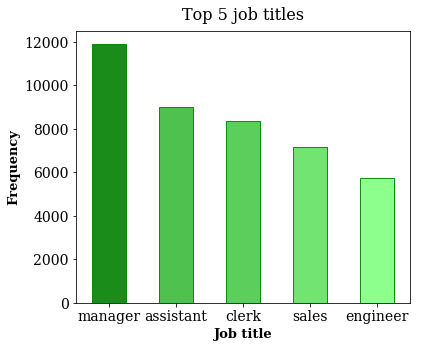

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mp
import numpy as np

in_titles = ititles_df.groupby('title').size().sort_values(ascending=False).head(5)
plt.figure(figsize=(6,5))

likeability_scores = np.array(in_titles)
 
data_normalizer = mp.colors.Normalize()

color_map = mp.colors.LinearSegmentedColormap(
    "my_map",
    {
        "red": [(0, 0.50, 0.5),
                 (1.0, 0, 0)],
        "green": [(0, 0.5, 1.0),
                (1.0, 0.5, 1.0)],
        "blue": [ (0, 0.5, 0.5),
                  (1.0, 0, 0)]
    }
)
    

in_titles.plot(kind="bar",alpha=0.9,color=color_map(data_normalizer(likeability_scores)),edgecolor='green')
plt.ylabel('Frequency', fontsize = 13, weight = 'bold')
plt.xlabel('Job title', fontsize = 13, weight = 'bold',position=(0.5,1.5))
plt.rcParams['font.family'] = "serif"
plt.xticks(fontsize='14')
plt.yticks(fontsize='14')
plt.title('Top 5 job titles',fontsize='16',y=1.02)
plt.xticks(rotation=0)

plt.show()


In [ ]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

p = sns.countplot(data=ititles_df,x="title")


In [7]:
jaccard_d = spark.sql("SELECT jaccard,job_title FROM data group by jaccard,job_title")
jaccard_df = jaccard_d.toPandas()
jaccard_df

,jaccard,job_title
0,0.500000,"[senior, associate]"
1,0.666667,"[payroll, accounting, manager]"
2,0.666667,"[relationship, manager]"
3,0.500000,"[technical, support, agent]"
4,0.750000,"[gas, station, attendant]"
5,1.000000,"[math, tutor]"
6,0.500000,"[documentation, clerk]"
7,1.000000,[busser]
8,0.500000,"[shipping, coordinator, customer, service]"
9,0.500000,"[barista, waiter]"


In [8]:
hist_df = jaccard_df['jaccard'].value_counts().rename('count')
hist_df = hist_df.to_frame().reset_index().rename({'index':'jaccard'},axis=1)
hist_df

,jaccard,count
0,0.500000,85851
1,0.666667,32161
2,0.600000,6964
3,1.000000,6777
4,0.750000,6097
5,0.800000,131
6,0.571429,90
7,0.833333,4
8,0.714286,3


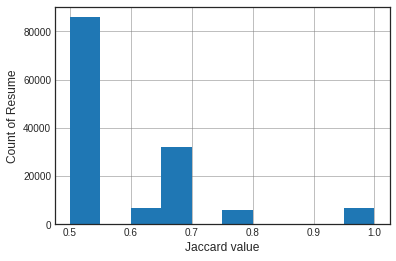

In [51]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import hist
hist(hist_df['jaccard'], weights=hist_df['count'])
plt.ylabel('Count of Resume', fontsize=12)
plt.xlabel('Jaccard value', fontsize=12)
plt.grid(color='grey', linestyle='-', linewidth=0.5)

In [11]:
jaccard_df

,jaccard,job_title
0,0.500000,"[senior, associate]"
1,0.666667,"[payroll, accounting, manager]"
2,0.666667,"[relationship, manager]"
3,0.500000,"[technical, support, agent]"
4,0.750000,"[gas, station, attendant]"
5,1.000000,"[math, tutor]"
6,0.500000,"[documentation, clerk]"
7,1.000000,[busser]
8,0.500000,"[shipping, coordinator, customer, service]"
9,0.500000,"[barista, waiter]"


In [12]:
count = 0
for i in jaccard_df['job_title']:
    if len(i)>1:
        count += 1
print("Number of Resumes that have job tokens greater than 1 are: " + str(count))

Number of Resumes that have job tokens greater than 1 are: 136506


In [13]:
mask = jaccard_df['job_title'].str.len() > 1
jaccard_2 = jaccard_df.loc[mask]
sc1 = jaccard_2['jaccard'].value_counts().rename('count')
sc1 = sc1.to_frame().reset_index().rename({'index':'jaccard'},axis=1)
sc1

,jaccard,count
0,0.500000,84975
1,0.666667,32161
2,0.600000,6964
3,0.750000,6097
4,1.000000,6081
5,0.800000,131
6,0.571429,90
7,0.833333,4
8,0.714286,3


In [14]:
mask1 = jaccard_df['job_title'].str.len() == 1
jaccard_3 = jaccard_df.loc[mask1]
sc2 = jaccard_2['jaccard'].value_counts().rename('count')
sc2 = sc2.to_frame().reset_index().rename({'index':'jaccard'},axis=1)
sc2

,jaccard,count
0,0.500000,84975
1,0.666667,32161
2,0.600000,6964
3,0.750000,6097
4,1.000000,6081
5,0.800000,131
6,0.571429,90
7,0.833333,4
8,0.714286,3


In [37]:
decimals = 2    
sc2['jaccard'] = sc2['jaccard'].apply(lambda x: round(x, decimals))
sc2

,jaccard,count
0,0.50,84975
1,0.67,32161
2,0.60,6964
3,0.75,6097
4,1.00,6081
5,0.80,131
6,0.57,90
7,0.83,4
8,0.71,3


Text(0.5, 1.0, 'Jaccard value for 1 token of Job titles')

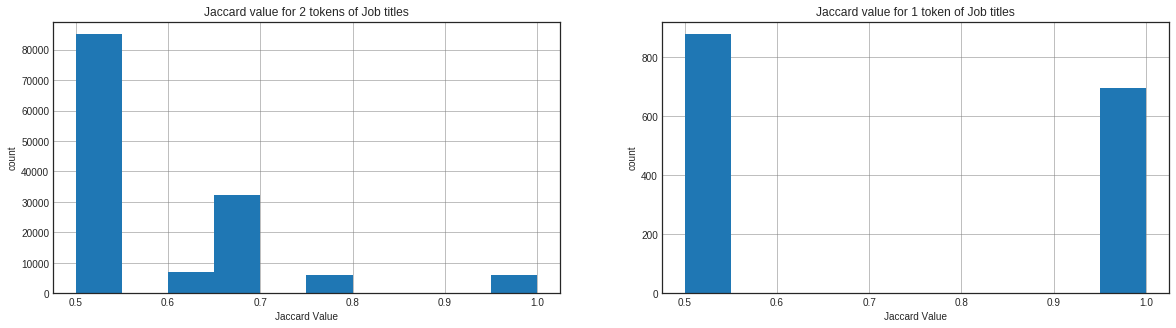

In [48]:
fig, ax = plt.subplots(1, 2,figsize=(20,5))

ax[0].hist(jaccard_2['jaccard'])
ax[0].set_xlabel('Jaccard Value')
ax[0].set_ylabel('count')
ax[0].grid(color='grey', linestyle='-', linewidth=0.5)
ax[0].set_title('Jaccard value for 2 tokens of Job titles')


ax[1].hist(jaccard_3['jaccard'])
ax[1].set_xlabel('Jaccard Value')
ax[1].set_ylabel('count')
ax[1].grid(color='grey', linestyle='-', linewidth=0.5)
ax[1].set_title('Jaccard value for 1 token of Job titles')


#ax[0].bar(sc2['jaccard'],sc2['count'])

# sc1["jaccard"].plot(ax=ax[0],kind='bar')
#ax[0].set_xlim(0,0.5)
